# Building a multi-output model with Keras

In this post, we have explored the Keras functional API in order to build a multi-output Deep Learning model. We have shown how to train a single model that is capable of predicting three distinct outputs. By using the UTK Face dataset, which is composed of over 20 thousand pictures of people in uncontrolled environments, we have predicted the age, gender for each record presented in the dataset, reaching an accuracy of 89% for gender and 87% for age.

## The Dataset

The UTKFace dataset is a large dataset composed of over 20 thousand face images with their respectivce annotations of age, gender and ethnicity. The images are properly cropped into the face region, but display some variations in pose, illumination, resolution, etc.

In order to retrieve the annotations of each record, we need to parse the filenames. Each record is stored in the following format: "age_gender_race_date&time.jpg"
Where:
    age is an integer from 0 to 116
    gender is an integer in which 0 represents male and 1 represents female
    race is an integer from 0 to 4, denoting white, black, asian, indian and others, respectively
    date and time, denoting when the picture was taken

We start by importing the required libraries and creating our dictionary to help us on parse the information from the dataset, along with some other information i.e. dataset location, training split, width and height of the samples.

In [3]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.utils import to_categorical
from PIL import Image

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Lambda
from keras.layers import Input
import tensorflow as tf


from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot


Using TensorFlow backend.


In [7]:
currentDirectory = os.getcwd()

In [8]:
dataset_name = os.path.join(currentDirectory, 'UTKFace/') 
onlyfiles = os.listdir(dataset_name)

In [9]:
len(onlyfiles)

23708

In [10]:
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

We also define a function to help us on extracting the data from our dataset. This function will be used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the fields (age, gender) of our records.

In [11]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [12]:
df = parse_dataset(dataset_name)
df.head()

age  gender   race                                               file
0  100.0    male  white  C:\Users\psen2\Desktop\MSIS\SpringSem\BigDataE...
1  100.0    male  white  C:\Users\psen2\Desktop\MSIS\SpringSem\BigDataE...
2  100.0  female  white  C:\Users\psen2\Desktop\MSIS\SpringSem\BigDataE...
3  100.0  female  white  C:\Users\psen2\Desktop\MSIS\SpringSem\BigDataE...
4  100.0  female  white  C:\Users\psen2\Desktop\MSIS\SpringSem\BigDataE...

## Data visualization

We perform some data visualization processes on our dataset to understand the data distribution. We start by defining a helper function to generate pie plots based on a given Pandas series:

In [13]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img_bytes = fig.to_image(format="jpg")
    display(Image(img_bytes))

### Gender distribution
For both male and female samples, we have quite a good balanced number of records, so we should have a good accuracy for both classes when using our model.

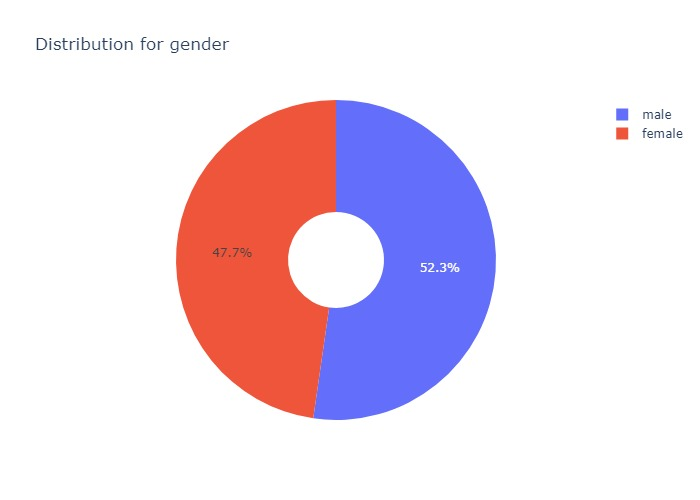

In [14]:
plot_distribution(df['gender'])

### Age distribution
We analyse how the age feature is distributed over the dataset by plotting a simple histogram with 20 bins.

We observe that our dataset is mostly composed of individuals whose age varies between 20 to 30 years, followed by individuals ranging from 30-40 years and then 40-60 years old. These groups represent around 70% of our dataset, so we expect to have a  good accuracy in predicting individuals in these ranges.

In [15]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

We also displayed the same plot in a pie plot by grouping the age column into bins

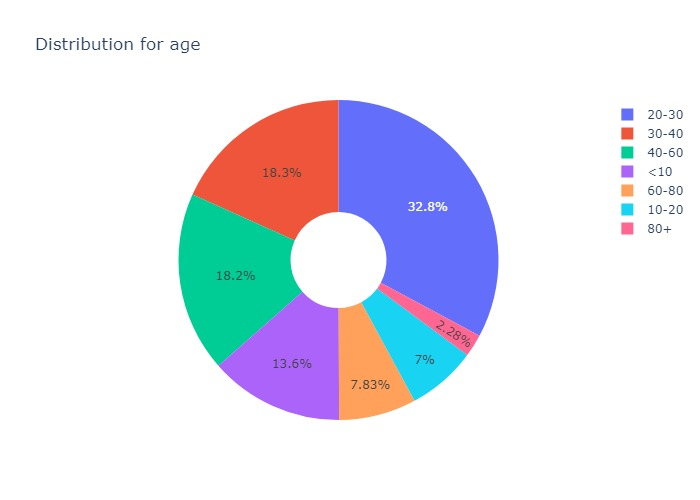

In [16]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

## Data Preprocessing

We convert colored images from BGR format to RGB format since we want to use both the Pillow function and the OpenCV function.


In [114]:
x_data =[]
for file in onlyfiles:
    face = cv2.imread(dataset_name+file)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face =cv2.resize(face, (32,32) )
    x_data.append(face)
x_data=np.array(x_data)
x_data.shape

x = np.squeeze(x_data)

# normalize data
x = x.astype('float32')
x /= 255
x.shape

(23708, 32, 32, 3)

### Gender

We start by creating two classes for gender - Male and Female

In [115]:
gender = [i.split('_')[1] for i in onlyfiles]

gender_classes = []
for i in gender:
    i = int(i)
    gender_classes.append(i)
    

Convert the gender_classes into categorical data

In [116]:
gender_categorical_labels = to_categorical(gender_classes, num_classes=2)
gender_categorical_labels[:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Divide Gender Data into Train, Test and Validate

In [121]:
(x_train_g, y_train_g), (x_test_g, y_test_g) = (x[:15008],gender_categorical_labels[:15008]) , (x[15008:] , gender_categorical_labels[15008:])
(x_valid_g , y_valid_g) = (x_test_g[:7000], y_test_g[:7000])
(x_test_g, y_test_g) = (x_test_g[7000:], y_test_g[7000:])

In [122]:
len(x_train_g)+len(x_test_g) + len(x_valid_g) == len(x)

True

## Age Modelling

We start by creating three age labels. First is Child for individuals aged 18 or below, Adult is for individuals with age 19 to 59 and Old for ages 60 and above.

In [119]:
age = [i.split('_')[0] for i in onlyfiles]

age_classes = []
for i in age:
    i = int(i)
    if i <= 18:
        age_classes.append(0)
    if (i>18) and (i<60):
        age_classes.append(1)
    if (i>=60):
        age_classes.append(2)
        


Convert the age_classes into categorical data

In [120]:
age_categorical_labels = to_categorical(age_classes, num_classes=3)
age_categorical_labels[:10]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Divide Age Data into Train, Test and Validate

In [123]:
(x_train_a, y_train_a), (x_test_a, y_test_a) = (x[:15008],age_categorical_labels[:15008]) , (x[15008:] , age_categorical_labels[15008:])
(x_valid_a , y_valid_a) = (x_test_a[:7000], y_test_a[:7000])
(x_test_a, y_test_a) = (x_test_a[7000:], y_test_a[7000:])

In [124]:
len(x_train_a)+len(x_test_a) + len(x_valid_a) == len(x)

True

## Data Augmentation
Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data 

The Keras deep learning library provides the ability to use data augmentation automatically when training a model.

This is achieved by using the ImageDataGenerator class.

First, the class may be instantiated and the configuration for the types of data augmentation are specified by arguments to the class constructor.

A range of techniques are supported, as well as pixel scaling methods. We will focus on five main types of data augmentation techniques for image data; specifically:

Image shifts via the width_shift_range and height_shift_range arguments.
Image flips via the horizontal_flip and vertical_flip arguments.
Image rotations via the rotation_range argument
Image brightness via the brightness_range argument.
Image zoom via the zoom_range argument.

## Sample input image for demonstration

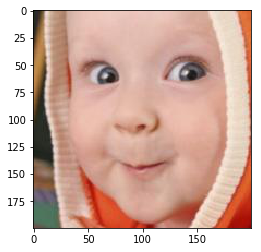

In [21]:
img = load_img('baby.jpg')
pyplot.imshow(img)

## Vertical shift image augmentation
Below is the same example updated to perform vertical shifts of the image via the height_shift_range argument, in this case specifying the percentage of the image to shift as 0.5 the height of the image. Running the example creates a plot of images augmented with random positive and negative vertical shifts.

We can see that both horizontal and vertical positive and negative shifts probably make sense for the chosen photograph, but in some cases, the replicated pixels at the edge of the image may not make sense to a model.

Note that other fill modes can be specified via “fill_mode” argument.

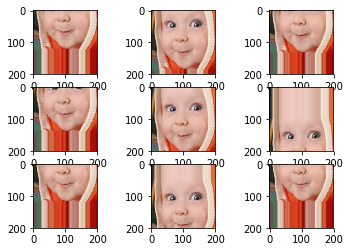

In [22]:
# example of vertical shift image augmentation
# load the image
img = load_img('baby.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(height_shift_range=0.5)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

## Horizontal flip image augmentation
An image flip means reversing the rows or columns of pixels in the case of a vertical or horizontal flip respectively.

The flip augmentation is specified by a boolean horizontal_flip or vertical_flip argument to the ImageDataGenerator class constructor. For photographs like the bird photograph used in this tutorial, horizontal flips may make sense, but vertical flips would not.

For other types of images, such as aerial photographs, cosmology photographs, and microscopic photographs, perhaps vertical flips make sense.

The example below demonstrates augmenting the chosen photograph with horizontal flips via the horizontal_flip argument.

Running the example creates a plot of nine augmented images.

We can see that the horizontal flip is applied randomly to some images and not others.

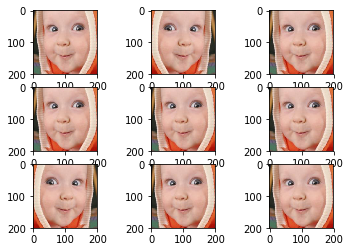

In [23]:
# load the image
img = load_img('baby.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

## Random rotation image augmentation
A rotation augmentation randomly rotates the image clockwise by a given number of degrees from 0 to 360.

The rotation will likely rotate pixels out of the image frame and leave areas of the frame with no pixel data that must be filled in.

The example below demonstrates random rotations via the rotation_range argument, with rotations to the image between 0 and 90 degrees.

Running the example generates examples of the rotated image, showing in some cases pixels rotated out of the frame and the nearest-neighbor fill.

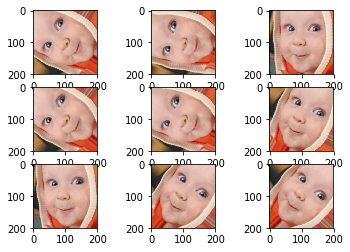

In [24]:
# load the image
img = load_img('baby.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

## Brighting image augmentation
The brightness of the image can be augmented by either randomly darkening images, brightening images, or both.

The intent is to allow a model to generalize across images trained on different lighting levels.

This can be achieved by specifying the brightness_range argument to the ImageDataGenerator() constructor that specifies min and max range as a float representing a percentage for selecting a brightening amount.

Values less than 1.0 darken the image, e.g. [0.5, 1.0], whereas values larger than 1.0 brighten the image, e.g. [1.0, 1.5], where 1.0 has no effect on brightness.

The example below demonstrates a brightness image augmentation, allowing the generator to randomly darken the image between 1.0 (no change) and 0.2 or 20%.

Running the example shows the augmented images with varying amounts of darkening applied.

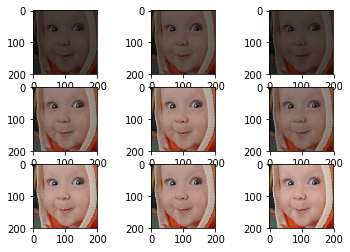

In [25]:
# load the image
img = load_img('baby.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

## Zoom image augmentation
A zoom augmentation randomly zooms the image in and either adds new pixel values around the image or interpolates pixel values respectively.

Image zooming can be configured by the zoom_range argument to the ImageDataGenerator constructor. You can specify the percentage of the zoom as a single float or a range as an array or tuple.

If a float is specified, then the range for the zoom will be [1-value, 1+value]. For example, if you specify 0.3, then the range will be [0.7, 1.3], or between 70% (zoom in) and 130% (zoom out).

The zoom amount is uniformly randomly sampled from the zoom region for each dimension (width, height) separately.

The zoom may not feel intuitive. Note that zoom values less than 1.0 will zoom the image in, e.g. [0.5,0.5] makes the object in the image 50% larger or closer, and values larger than 1.0 will zoom the image out by 50%, e.g. [1.5, 1.5] makes the object in the image smaller or further away. A zoom of [1.0,1.0] has no effect.

The example below demonstrates zooming the image in, e.g. making the object in the photograph larger.

Running the example generates examples of the zoomed image, showing a random zoom in that is different on both the width and height dimensions that also randomly changes the aspect ratio of the object in the image.

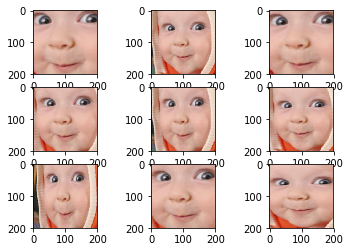

In [26]:
# load the image
img = load_img('baby.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [126]:
# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
) 


# Gender
train_datagen.fit(x_train_g)

train_generator_gender = train_datagen.flow(
x_train_g, y_train_g,
batch_size=64,
)


# Age
train_datagen.fit(x_train_a)

train_generator_age = train_datagen.flow(
x_train_a, y_train_a,
batch_size=64,
)


### Gender Model

We have taken 3 convolutional neural network layers and 3 dense layers for the Gender model

In [154]:
gender_model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
gender_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3))) 
gender_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
gender_model.add(tf.keras.layers.Dropout(0.3))

gender_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
gender_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
gender_model.add(tf.keras.layers.Dropout(0.3))

gender_model.add(tf.keras.layers.Flatten())
gender_model.add(tf.keras.layers.Dense(256, activation='relu'))
gender_model.add(tf.keras.layers.Dropout(0.5))
gender_model.add(tf.keras.layers.Dense(2, activation='sigmoid'))



In [155]:
# Take a look at the model summary
gender_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 64)        832       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)             

In [156]:
# Compiling the gender_model
gender_model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [157]:
gender_checkpointer = ModelCheckpoint(filepath='CNN.weights.best.gender.hdf5', 
                               verbose=1, save_best_only=True)

In [152]:
gender_model.fit(x_train_g,
         y_train_g,
         batch_size=64,
         epochs=100,
         callbacks=[gender_checkpointer],
         validation_data=(x_valid_g, y_valid_g))

Train on 15008 samples, validate on 7000 samples
Epoch 1/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.6348 - accuracy: 0.6377
Epoch 00001: val_loss improved from inf to 0.60171, saving model to CNN.weights.best.gender.hdf5
15008/15008 [==============================] - 22s 1ms/sample - loss: 0.6345 - accuracy: 0.6378 - val_loss: 0.6017 - val_accuracy: 0.7142
Epoch 2/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.5608 - accuracy: 0.7149
Epoch 00002: val_loss improved from 0.60171 to 0.52968, saving model to CNN.weights.best.gender.hdf5
15008/15008 [==============================] - 24s 2ms/sample - loss: 0.5610 - accuracy: 0.7148 - val_loss: 0.5297 - val_accuracy: 0.7571
Epoch 3/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.5081 - accuracy: 0.7493
Epoch 00003: val_loss improved from 0.52968 to 0.43696, saving model to CNN.weights.best.gender.hdf5
15008/15008 [==============================] - 24s 2ms/sample - loss: 0.5

14976/15008 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.8733
Epoch 00053: val_loss did not improve from 0.25192
15008/15008 [==============================] - 25s 2ms/sample - loss: 0.2884 - accuracy: 0.8731 - val_loss: 0.2558 - val_accuracy: 0.8914
Epoch 54/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.2942 - accuracy: 0.8720
Epoch 00054: val_loss did not improve from 0.25192
15008/15008 [==============================] - 24s 2ms/sample - loss: 0.2944 - accuracy: 0.8718 - val_loss: 0.2576 - val_accuracy: 0.8925
Epoch 55/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.8713
Epoch 00055: val_loss did not improve from 0.25192
15008/15008 [==============================] - 25s 2ms/sample - loss: 0.2891 - accuracy: 0.8712 - val_loss: 0.2662 - val_accuracy: 0.8920
Epoch 56/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.8776
Epoch 00056: val_loss did not improve 

Epoch 81/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.2682 - accuracy: 0.8823
Epoch 00081: val_loss did not improve from 0.24859
15008/15008 [==============================] - 29s 2ms/sample - loss: 0.2682 - accuracy: 0.8824 - val_loss: 0.2580 - val_accuracy: 0.8946
Epoch 82/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.2718 - accuracy: 0.8808
Epoch 00082: val_loss did not improve from 0.24859
15008/15008 [==============================] - 24s 2ms/sample - loss: 0.2717 - accuracy: 0.8808 - val_loss: 0.2499 - val_accuracy: 0.8966
Epoch 83/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8826
Epoch 00083: val_loss did not improve from 0.24859
15008/15008 [==============================] - 26s 2ms/sample - loss: 0.2689 - accuracy: 0.8828 - val_loss: 0.2521 - val_accuracy: 0.8979
Epoch 84/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.2682 - accuracy: 0.8836
Epoch 00084: val_loss did

### Gender model accuracy

We got an accuracy of 89% with the gender model

In [158]:
gender_model.load_weights(currentDirectory+"\CNN.weights.best.gender.hdf5")

# Re-evaluate the model
loss,acc = gender_model.evaluate(x_test_g,  y_test_g, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1700/1700 - 1s - loss: 0.2804 - accuracy: 0.8900
Restored model, accuracy: 89.00%


In [166]:
labels = ["Male", "Female"]

We plot a random sample of 15 test images, their predicted labels and ground truth for Gender. 

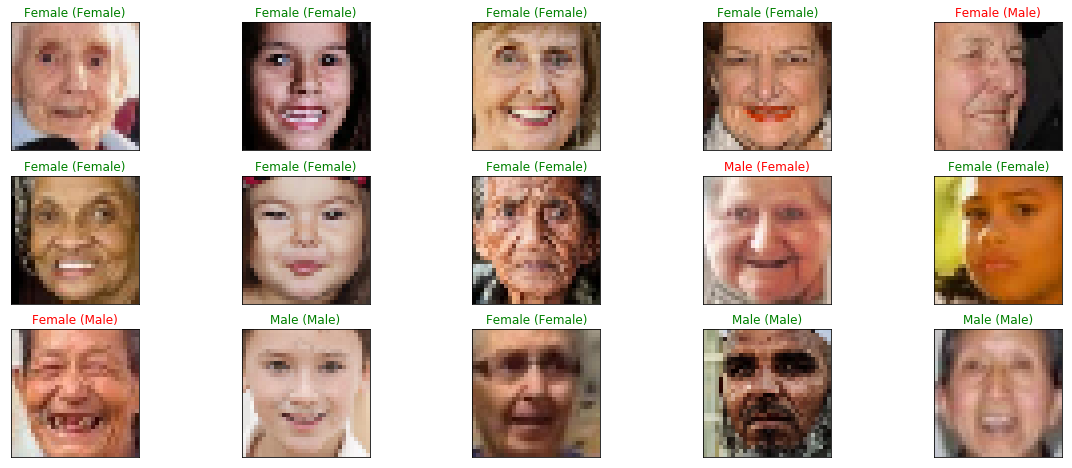

In [169]:
y_hat = gender_model.predict(x_test_g)

# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test_g.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test_g[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test_g[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()
    

### Age Model

We have taken 3 convolutional neural network layers and 3 dense layers for the Age model

In [176]:
age_model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
age_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3))) 
age_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
age_model.add(tf.keras.layers.Dropout(0.3))

age_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
age_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
age_model.add(tf.keras.layers.Dropout(0.3))

age_model.add(tf.keras.layers.Flatten())
age_model.add(tf.keras.layers.Dense(256, activation='relu'))
age_model.add(tf.keras.layers.Dropout(0.5))
age_model.add(tf.keras.layers.Dense(3, activation='sigmoid'))

In [177]:
# Take a look at the model summary
age_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 64)        832       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)             

In [178]:
age_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [179]:
from keras.callbacks import ModelCheckpoint
age_checkpointer = ModelCheckpoint(filepath='CNN.weights.best.age.hdf5', 
                               verbose=1, save_best_only=True)

In [185]:
age_model.fit(x_train_a,
         y_train_a,
         batch_size=64,
         epochs=100,
         callbacks=[age_checkpointer],
         validation_data=(x_valid_a, y_valid_a),)

Train on 15008 samples, validate on 7000 samples
Epoch 1/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.1046 - accuracy: 0.9619
Epoch 00001: val_loss did not improve from 0.79161
15008/15008 [==============================] - 23s 2ms/sample - loss: 0.1045 - accuracy: 0.9620 - val_loss: 1.6929 - val_accuracy: 0.7691
Epoch 2/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.1019 - accuracy: 0.9621
Epoch 00002: val_loss did not improve from 0.79161
15008/15008 [==============================] - 25s 2ms/sample - loss: 0.1025 - accuracy: 0.9619 - val_loss: 1.6874 - val_accuracy: 0.7674
Epoch 3/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9605
Epoch 00003: val_loss did not improve from 0.79161
15008/15008 [==============================] - 20s 1ms/sample - loss: 0.1042 - accuracy: 0.9606 - val_loss: 1.5808 - val_accuracy: 0.7719
Epoch 4/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.1016

Epoch 29/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9703
Epoch 00029: val_loss did not improve from 0.79161
15008/15008 [==============================] - 21s 1ms/sample - loss: 0.0806 - accuracy: 0.9703 - val_loss: 2.6996 - val_accuracy: 0.7676
Epoch 30/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9693 ETA: 0s - loss: 0.0813 - accuracy: 
Epoch 00030: val_loss did not improve from 0.79161
15008/15008 [==============================] - 21s 1ms/sample - loss: 0.0812 - accuracy: 0.9693 - val_loss: 2.5495 - val_accuracy: 0.7686
Epoch 31/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9694
Epoch 00031: val_loss did not improve from 0.79161
15008/15008 [==============================] - 21s 1ms/sample - loss: 0.0798 - accuracy: 0.9692 - val_loss: 2.4287 - val_accuracy: 0.7671
Epoch 32/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.0759 - accura

14976/15008 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9742
Epoch 00057: val_loss did not improve from 0.79161
15008/15008 [==============================] - 21s 1ms/sample - loss: 0.0651 - accuracy: 0.9742 - val_loss: 3.2016 - val_accuracy: 0.7634
Epoch 58/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9754
Epoch 00058: val_loss did not improve from 0.79161
15008/15008 [==============================] - 21s 1ms/sample - loss: 0.0680 - accuracy: 0.9754 - val_loss: 3.1546 - val_accuracy: 0.7653
Epoch 59/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9734
Epoch 00059: val_loss did not improve from 0.79161
15008/15008 [==============================] - 21s 1ms/sample - loss: 0.0657 - accuracy: 0.9732 - val_loss: 3.1091 - val_accuracy: 0.7634
Epoch 60/100
14976/15008 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.9757
Epoch 00060: val_loss did not improve 

### Age model accuracy

We got an accuracy of 87% with the age model

In [181]:
age_model.load_weights(currentDirectory+"\CNN.weights.best.age.hdf5")

# Re-evaluate the model
loss,acc = age_model.evaluate(x_test_a,  y_test_a, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1700/1700 - 1s - loss: 0.5466 - accuracy: 0.8700
Restored model, accuracy: 87.00%


In [182]:
labels_a =["CHILD", "ADULT", "OLD"]

We plot a random sample of 15 test images, their predicted labels and ground truth for Gender.

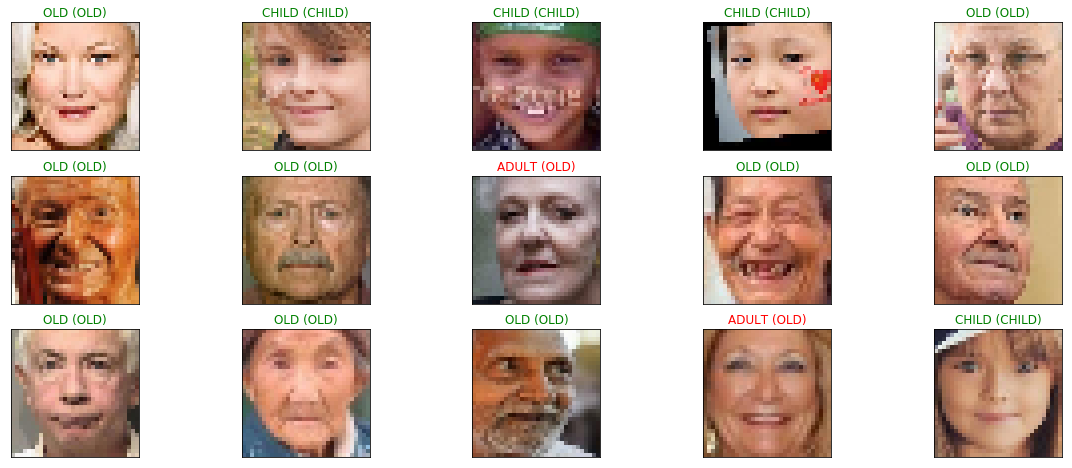

In [183]:
y_hat_a = age_model.predict(x_test_a)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test_a.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test_a[index]))
    predict_index = np.argmax(y_hat_a[index])
    true_index = np.argmax(y_test_a[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels_a[predict_index], 
                                  labels_a[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()